# Django 11 DRF 02

## DRF with N:1 Relation

### 사전 준비

#### Comment 모델 정의
- Comment 클래스 정의 및 데이터베이스 초기화
```py
# articles/models.py 
    class Comment(models.Model): 
        article = models.ForeignKey(Article, on_delete=models.CASCADE) 
        content = models.TextField() 
        created_at = models.DateTimeField(auto_now_add=True) 
        updated_at = models.DateTimeField(auto_now=True)
```
- Migration 및 fixture 데이터 업로드
```shell
    $ python manage.py makemigrations 
    $ python manage.py migrate 
    $ python manage.py loaddata articles.json comments.json
```

#### URL 및 HTTP request method 구성
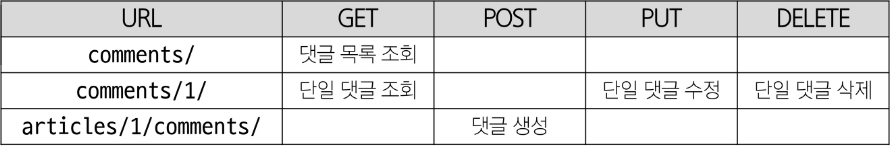

### GET method

#### GET - List
- 댓글 목록 조회를 위한 CommentSerializer
```py
    # articles/serializers.py 
    
    from .models import Article, Comment 
    
    class CommentSerializer(serializers.ModelSerializer): 
        class Meta: 
            model = Comment 
            fields = '__all__'
```
- url 작성
```py
    urlpatterns = [
        ...,
        path('comments/', views.comment_list), 
    ]
```
- view 함수 작성
```py
    #articles/views.py 
    
    from.models import Article, Comment 
    from.serializers import ArticleListSerializer, ArticleSerializer, CommentSerializer 
    

    @api_view(['GET']) 
    def comment_list(request): 
        comments = Comment.objects.all() 
        serializer = CommentSerializer(comments, many=True) 
        return Response (serializer.data)
```
- GET http://127.0.0.1:8000/api/v1/comments/응답 확인

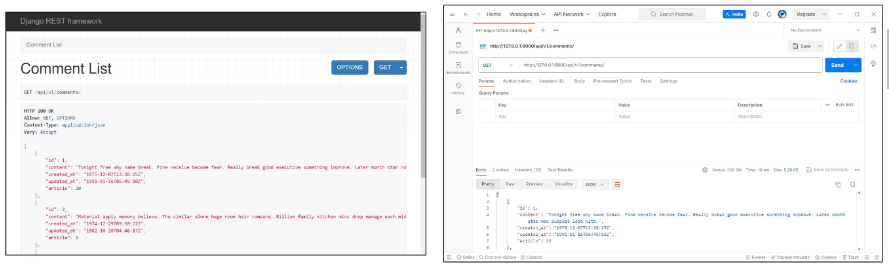

#### GET - Detail
- 단일 댓글 조회를 위한 url 및 view 함수 작성
```py
    # articles/urls.py 
    
    urlpatterns = [ 
        ...,
        path('comments/<int:comment_pk>/', views.comment_detail), 
    ]
```
```py
    # articles/views.py 
    
    @api_view(['GET']) 
    def comment_detail(request, comment_pk): 
        comment = Comment.objects.get(pk=comment_pk) 
        serializer = CommentSerializer(comment) 
        return Response (serializer.data)
```
- GET http://127.0.0.1:8000/api/v1/comments/1/응답 확인

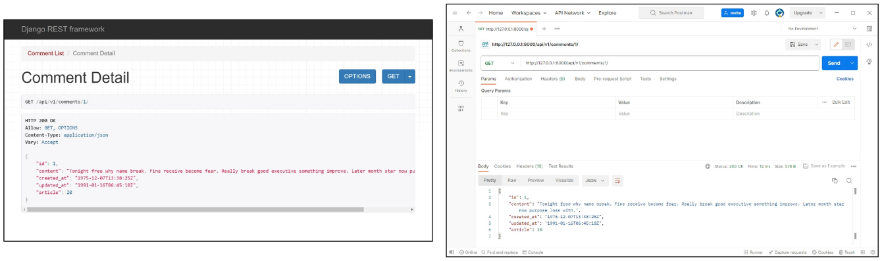

### POST method

#### POST
- 단일 댓글 생성을 위한 url 및 view 함수 작성
```py
    # articles/urls.py
    
    urlpatterns = [ 
        ...,
        path('articles/<int:article_pk>/comments/', views.comment_create), 
    ]
```
```py
    # articles/views.py
    
    @api_view(['POST']) 
    def comment_create(request, article_pk): 
        article = Article.objects.get(pk=article_pk)
        serializer = CommentSerializer(data=request.data) 
        if serializer.is_valid(raise_exception=True): 
            serializer.save() 
            return Response(serializer.data, status=status.HTTP_201_CREATED)
```
- serializer 인스턴스의 save() 메서드는 특정 Serializer 인스턴스를 저장하는 과정에서 추가 데이터를 받을 수 있음
```py
    #articles/views.py 
    
    @api_view(['POST']) 
    def comment_create(request, article_pk): 
        article = Article.objects.get(pk=article_pk) 
        serializer = CommentSerializer(data=request.data) 
        if serializer.is_valid(raise_exception=True): 
            `serializer.save(article=article)`
            return Response (serializer.data, status=status.HTTP_201_CREATED)
```
- POST http://127.0.0.1:8000/api/v1/articles/1/comments/응답 확인
- > 상태코드 400 응답 확인

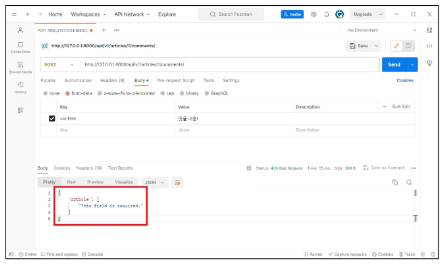

- > CommentSerializer에서 외래 키에 해당하는 article field 또한 사용자로부터 입력 받도록 설정되어 있기 때문에 서버 측에서는 누락되었다고 판단한 것
- > 유효성 검사 목록에서 제외 필요
- > article field를 읽기 `전용 필드`로 설정하기

##### 읽기 전용 필드(read_only_fields)
- 데이터를 전송 받은 시점에 `“유효성 검사에서 제외시키고, 데이터 조회 시에는 출력"` 하는 필드
```py
    # articles/serializers.py 
    
    class CommentSerializer(serializers. ModelSerializer): 
        class Meta: 
            model = Comment 
            fields = '__all__' 
            `read_only_fields = ('article',)`
```

#### POST
- POST http://127.0.0.1:8000/api/v1/articles/1/comments/ 재요청

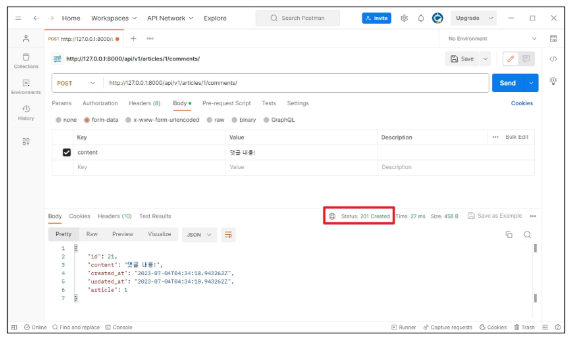

### DELETE & PUT method

#### DELETE & PUT
- 단일 댓글 삭제 및 수정을 위한 view 함수 작성
```py
    # articles/views.py

    @api_view(['GET', 'DELETE', 'PUT']) 
    def comment_detail(request, comment_pk): 
        comment = Comment.objects.get(pk=comment_pk) 
        if request.method == 'GET': 
            serializer = CommentSerializer(comment) 
            return Response(serializer.data) 
        
        elif request.method == 'DELETE': 
            comment.delete() 
            return Response(status=status.HTTP_204_NO_CONTENT) 
        
        elif request.method == 'PUT': 
            serializer = CommentSerializer(comment, data=request.data) 
            if serializer.is_valid(raise_exception=True): 
                serializer.save() 
                return Response (serializer.data)
```
- DELETE http://127.0.0.1:8000/api/v1/comments/21/ 응답 확인

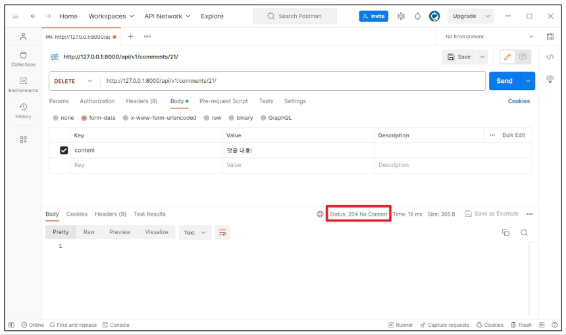

- PUT http://127.0.0.1:8000/api/v1/comments/1/ 응답 확인

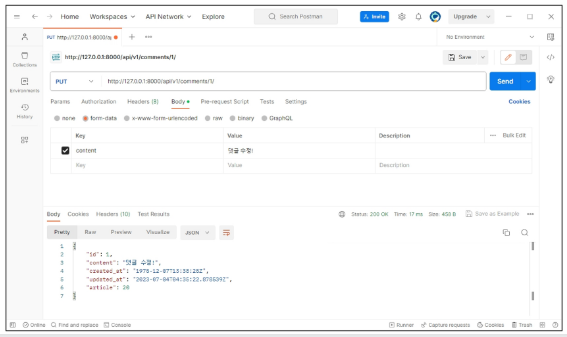

### 응답 데이터 재구성

#### 댓글 조회 시 게시글 출력 내역 변경
- 댓글 조회 시 게시글 번호만 제공해주는 것이 아닌 '게시글의 제목'까지 제공하기

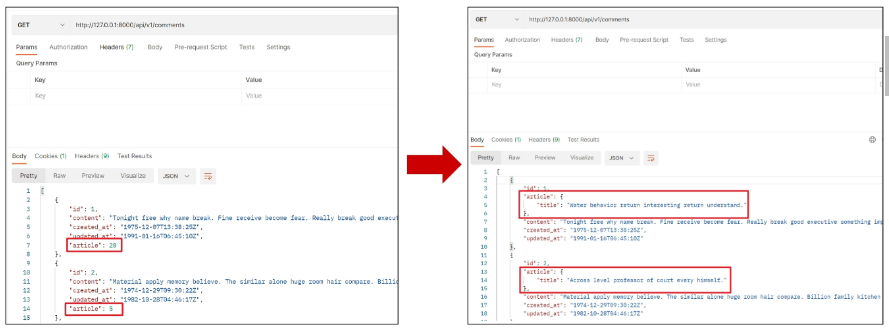
- 필요한 데이터를 만들기 위한 Serializer는 내부에서 추가 선언이 가능
```py
    # articles/serializers.py 
    
    class CommentSerializer(serializers.ModelSerializer): 
        class ArticleTitleSerializer(serializers.ModelSerializer): 
            class Meta: 
                model = Article 
                fields = ('title',) 

        article = ArticleTitleSerializer(read_only=True) 
        
        class Meta: 
            model = Comment 
            fields = '__all__' 
            # read_only_fields = ('article',)
```
- GET http://127.0.0.1:8000/api/v1/comments/1/ 응답 확인

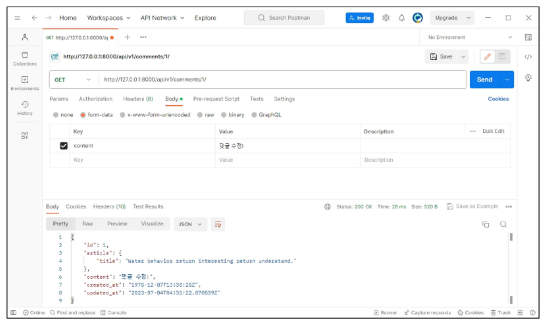

## 역참조 데이터 구성

### Article → Comment 간 역참조 관계를 활용한 JSON 데이터 재구성
- 아래 2가지 사항에 대한 데이터 재구성하기 
    1. 단일 게시글 조회 시 `해당 게시글에 작성된 댓글 목록`도 함께 붙여서 응답 
    2. 단일 게시글 조회 시 `해당 게시글에 작성된 댓글 개수`도 함께 붙여서 응답

### 단일 게시글 + 댓글 목록

#### 1. 단일 게시글 + 댓글 목록
- Nested relationships (역참조 매니저 활용) 
    - 모델 관계 상으로 참조하는 대상은 참조되는 대상의 표현에 포함되거나 중첩될 수 있음
    - 이러한 중첩된 관계는 serializers를 필드로 사용하여 표현 가능
```py
    # articles/serializers.py 
    
    class ArticleSerializer(serializers.ModelSerializer): 
        class CommentDetailSerializer(serializers. ModelSerializer): 
            class Meta: 
                model = Comment 
                fields = ('id', 'content',) 
        comment_set = CommentDetailSerializer(many=True, read_only=True) 
        
        class Meta: 
            model = Article 
            fields = '__all__'
```
- GET http://127.0.0.1:8000/api/v1/articles/2/ 응답 확인

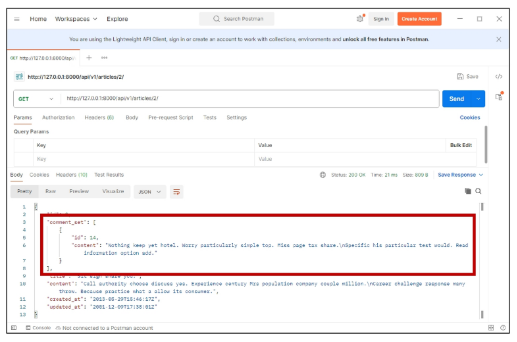

### 단일 게시글 + 댓글 갯수

#### 2. 단일 게시글 + 댓글 갯수
- 댓글 개수에 해당하는 새로운 필드 생성
```py
    # articles/serializers.py 
    
    class ArticleSerializer(serializers.ModelSerializer): 
        ...
        comment_set = CommentSerializer(many=True, read_only=True) 
        comment_count = serializers.IntegerField(source='comment_set.count', read_only=True)
        
     class Meta: 
        model = Article 
        fields = '__all__'
```
- GET http://127.0.0.1:8000/api/v1/articles/3/ 응답 확인

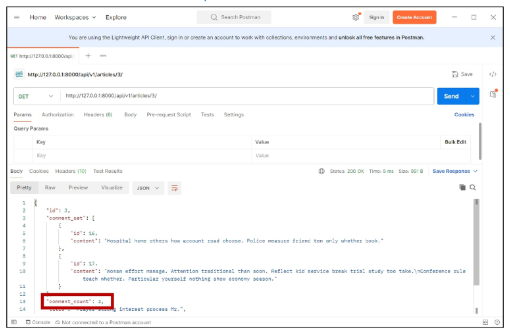

#### 'source' arguments
- 필드를 채우는 데 사용할 속성의 이름
- 점 표기법(dotted notation)을 사용하여 속성을 탐색할 수 있음

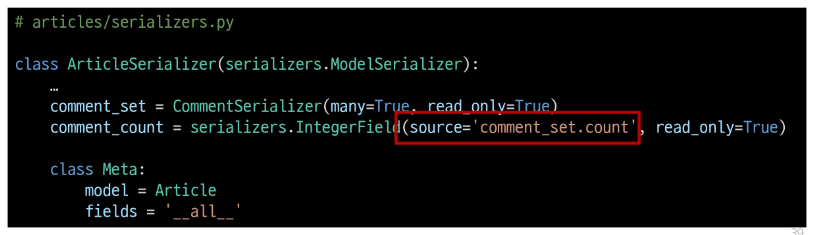

#### ※주의※ 읽기 전용 필드 지정 이슈
- 특정 필드를 override 혹은 추가한 경우 read_only_fields는 동작하지 않음 
- > 이런 경우 새로운 필드에 read_only 키워드 인자로 작성해야 함

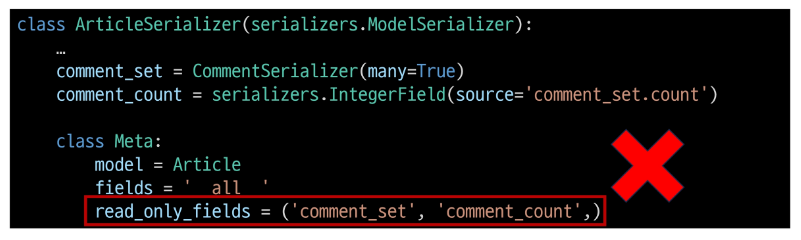

### 읽기 전용 필드

#### 읽기 전용 필드를 사용하는 이유
- 사용자에게 입력으로는 받지 않지만 제공은 해야하는 경우
- 새로운 필드 값을 만들어 제공해야 하는 경우

- 특징 및 주의 사항
    - 유효성 검사에서 제외됨
    - 단, 유효성 검사에서 제외된다고 해서 반드시 '생성' 로직에서만 사용이 국한되는 것은 아님

#### read_only_fields 속성과 read_only 인자의 사용처
- read_only_fields
    - 기존 외래 키 필드 값을 그대로 응답 데이터에 제공하기 위해 지정하는 경우

- read_only
    - 기존 외래 키 필드 값의 결과를 다른 값으로 덮어쓰는 경우
    - 새로운 응답 데이터 값을 제공하는 경우

## API 문서화

### 개요

#### OpenAPI Specification
##### OAS
RESTful API를 설명하고 시각화하는 표준화된 방법

- > API에 대한 세부사항을 기술할 수 있는 공식 표준

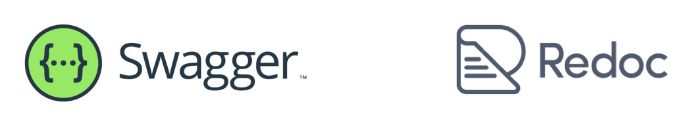

**OAS 기반 API에 대한 문서를 생성하는 데 도움을 주는 오픈소스 프레임워크**

### 문서화 활용

### drf-spectacular 라이브러리
- DRF 위한 OpenAPI 3.O 구조 생성을 도와주는 라이브러리
- 설치 및 등록
    ```shell
    $ pip install drf-spectacular
    ```
    ```py
    # settings.py 
    
    INSTALLED_APPS = [ 
        ...,
        'drf_spectacular', 
        ...,
    ]
    ```

- 관련 설정 코드 입력 (OpenAPI 구조 자동 생성 코드)
    ```py
    # settings.py 
    
    REST_FRAMEWORK = { 
        # YOUR SETTINGS 
        'DEFAULT_SCHEMA_CLASS': 'drf_spectacular.openapi.AutoSchema', 
    }
    ```

- swagger, redoc 페이지 제공을 위한 url 작성
    ```py
    # drf/urls.py
    
    from drf_spectacular.views import SpectacularAPIView, SpectacularRedocView, SpectacularSwaggerView 
    
    urlpatterns = [ 
        ...,
        path('api/schema/', SpectacularAPIView.as_view(), name='schema'), 
        path('api/schema/swagger-ui/', SpectacularSwaggerView.as_view(url_name='schema'), name='swagger-ui'), 
        path('api/schema/redoc/', SpectacularRedocView.as_view(url_name='schema'), name='redoc'),
    ]
    ```

- http://127.0.0.1:8000/api/schema/swagger-ui/ 페이지 확인

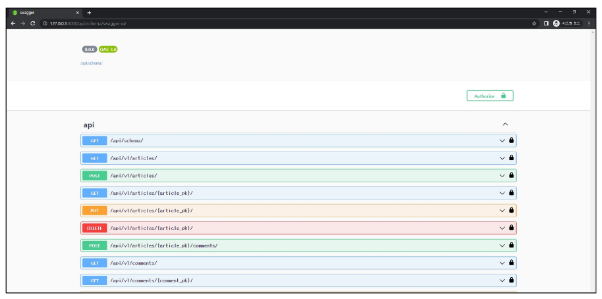

- http://127.0.0.1:8000/api/schema/redoc/ 페이지 확인

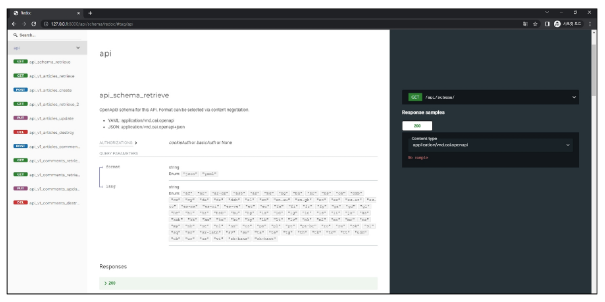

#### "설계 우선" 접근법
- OAS의 핵심 이점
- API를 먼저 설계하고 명세를 작성한 후, 이를 기반으로 코드를 구현하는 방식
- API의 일관성을 유지하고, API 사용자는 더 쉽게 API를 이해하고 사용할 수 있음
- 또한, OAS를 사용하면 API가 어떻게 작동하는 지를 시각적으로 보여주는 문서를 생성할 수 있으며, 이는 API를 이해하고 테스트하는 데 매우 유용

- > 이런 목적으로 사용되는 도구가 Swagger-UI 또는 ReDoc

## 참고

### 올바르게 404 응답하기

#### Django shortcuts functions
**render()**

**redirect()**

**`get_object_or_404()`**

**`get_list_or_404()`**

#### get_object_or_404()
모델 manager objects에서 get()을 호출하지만, 해당 객체가 없을 땐 기존 DoesNotExist 예외 대신 `Http404를 raise` 함

#### get_object_or_404 적용
```py
# articles/views.py 

from django.shortcuts import get_object_or_404 


article = Article.objects.get(pk=article_pk) 
comment = Comment.objects.get(pk=comment_pk) 

#위 코드를 모두 다음과 같이 변경 
article = get_object_or_404(Article, pk=article_pk) 
comment = get_object_or_404(Comment, pk=comment_pk)
```

#### get_list_or_404()
모델 manager objects에서 filter()의 결과를 반환하고, 해당 객체 목록이 없을 땐 `Http404를 raise` 함

#### get_list_or_404 적용
```py
# articles/views.py 

from django.shortcuts import get_object_or_404, get_list_or_404 


articles = Article.objects.all() 
comments = Comment.objects.all() 

#위 코드를 모두 다음과 같이 변경 
articles = get_list_or_404(Article) 
comments = get_list_or_404(Comment)
```

#### 적용 전/후 비교
존재하지 않는 게시글 조회 시 이전에는 상태 코드 500을 응답했지만 현재는 404를 응답

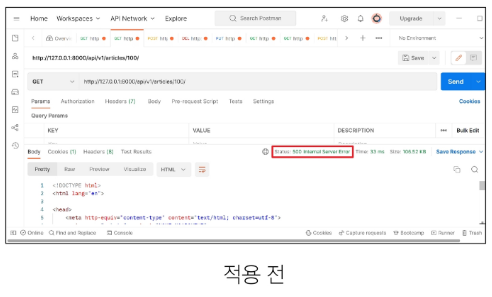

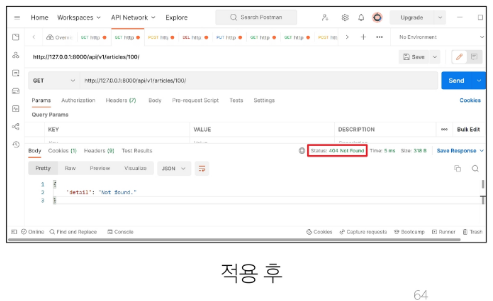

#### 왜 사용해야 할까?
- 클라이언트에게 "서버에 오류가 발생하여 요청을 수행할 수 없다(500)" 라는 원인이 정확하지 않은 에러를 제공하기 보다는, 적절한 예외 처리를 통해 클라이언트에게 보다 정확한 에러 현황을 전달하는 것도 매우 중요한 개발 요소 중 하나이기 때문

### 복잡한 ORM 활용

#### 복잡한 ORM 활용 시 권장 방식
- 복잡한 query나 로직은 View 함수에서 진행
    - 여러 모델을 조인하거나 복잡한 집계가 필요한 경우 View 함수에서 처리
    - 필요한 경우 View 함수에서 select_related()나 prefatch_related()를 사용하여 query를 최적화

- Serializer는 기본적인 데이터 변환을 담당
    - Serializer만으로는 복잡한 query를 처리하기 어려움